In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [2]:
import torch

In [3]:
import matplotlib.pyplot as plt

from psipy.model import MASOutput

In [4]:
mas_path = './corona'
model = MASOutput(mas_path)

print(model)

MAS output in directory corona
MASOutput
Variables: ['bp', 'br', 'bt', 'cs', 'em', 'ep', 'heat', 'jp', 'jr', 'jt', 'p', 'rho', 't', 'va', 'vp', 'vr', 'vt']


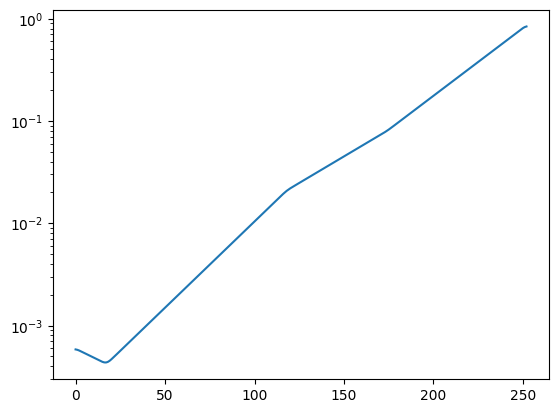

In [5]:
plt.plot(np.diff(model['vr'].data['r']))
plt.yscale('log')

In [6]:
model['vr'].data['phi']

<xarray.DataArray 'phi' (phi: 300)>
array([-0.010542,  0.010542,  0.031627, ...,  6.251558,  6.272643,  6.293727])
Coordinates:
  * phi      (phi) float64 -0.01054 0.01054 0.03163 ... 6.252 6.273 6.294

In [7]:
model['vr'].data['r'][80]/(model['vr'].data['r'][80] - model['vr'].data['r'][81])

<xarray.DataArray 'r' ()>
array(-233.74830694)
Coordinates:
    r        float64 1.119

In [8]:
model['vr'].data.interp(r=2, theta=0, phi=0)

<xarray.DataArray 'vr' (time: 1)>
array([42.1816969])
Coordinates:
  * time     (time) int64 2
    r        int64 2
    theta    int64 0
    phi      int64 0

(0.0, 5.0)

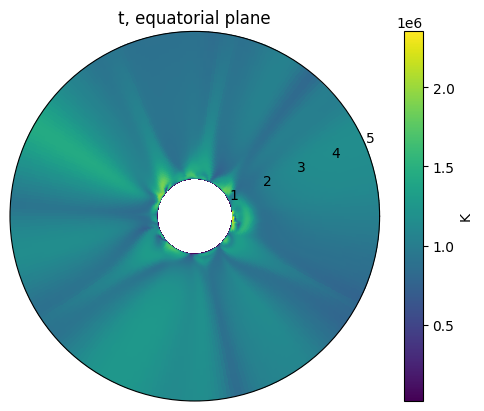

In [9]:
ax = plt.subplot(projection="polar")
model["t"].plot_equatorial_cut(ax=ax)
ax.set_rlim(0, 5)

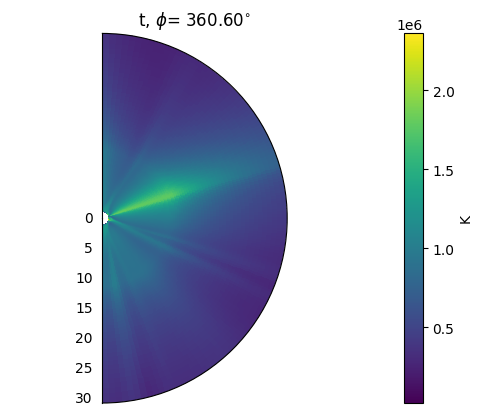

In [10]:
ax = plt.subplot(projection="polar")
mdt = model["t"]
mdt.plot_phi_cut(-1,ax=ax)


(0.0, 5.0)

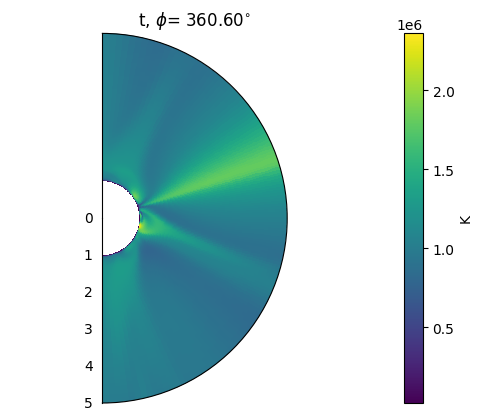

In [11]:
ax = plt.subplot(projection="polar")
mdt = model["t"]
mdt.plot_phi_cut(-1,ax=ax)
ax.set_rlim(0, 5)


In [12]:

x_grid  =  np.linspace(-6, 6, 300)
y_grid  =  np.linspace(-6, 6, 300)
z_grid  =  np.linspace(-6, 6, 300)

# grid spacing
dx_g = x_grid[1] - x_grid[0]
dy_g = y_grid[1] - y_grid[0]
dz_g = z_grid[1] - z_grid[0]

def xyz_to_rtp(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arcsin(z/r)
    phi = np.arctan2(y, x)
    # <0 +2pi
    phi = (phi + 2*np.pi) % (2*np.pi)
    return r, theta, phi

def rtp_to_xyz(r, theta, phi):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

x_mesh, y_mesh, z_mesh = np.meshgrid(x_grid, y_grid, z_grid, indexing='ij')

r_mesh, theta_mesh, phi_mesh = xyz_to_rtp(x_mesh, y_mesh, z_mesh)

# 1. interpolate the x,y,z to r,theta,phi for only Ne
# 2. Do 2D ne ray tracing

# long term TODO, dynamic cell size

# this cell take 3min to run, needs to be optimized 

In [13]:
from astropy import units as u

rhoxyz = model['rho'].sample_at_coords(lon=phi_mesh.reshape(-1)*180/np.pi*u.deg,
                              lat=theta_mesh.reshape(-1)*180/np.pi*u.deg,
                              r=r_mesh.reshape(-1)*u.Rsun).value

# time consuming (13min)

/opt/devel/peijin/solarenv/lib/python3.8/site-packages/psipy/model/variable.py:454: UserWarning: At least one sample coordinate is outside bounds (0.9997080564498901, 30.419034957885742) in r dimension. Sample coordinate min/max values are (0.03475687239268571, 10.392304845413264).
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
rhoxyz = rhoxyz.reshape(x_mesh.shape)

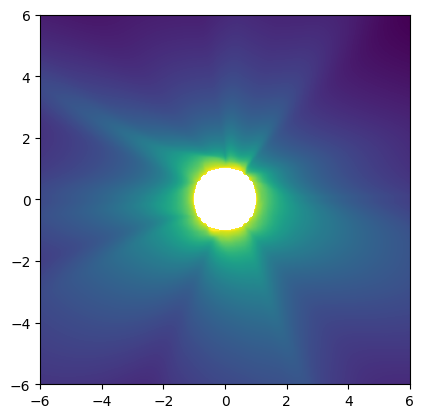

In [ ]:
plt.imshow(np.log(rhoxyz[150,:,:]),vmax=20,extent= [x_grid[0], x_grid[-1], y_grid[0], y_grid[-1]])

In [ ]:
drho_dx = np.gradient(rhoxyz, dx_g, axis=0)
drho_dy = np.gradient(rhoxyz, dy_g, axis=1)
drho_dz = np.gradient(rhoxyz, dz_g, axis=2)


Text(0.5, 1.0, '$d\\rho/dz$ at y=0')

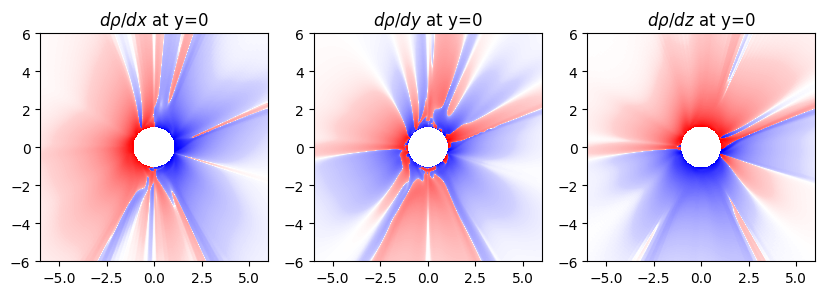

In [ ]:
from matplotlib import colors

fig, ax = plt.subplots(1, 3, figsize=(10, 3.333))
slicedatax = drho_dx[:,150,:].T
slicedatay = drho_dy[:,150,:].T
slicedataz = drho_dz[:,150,:].T

ax = ax.flatten()
ax[0].imshow(slicedatax,cmap='bwr',extent= [x_grid[0], x_grid[-1], y_grid[0], y_grid[-1]],
            norm=colors.SymLogNorm(linthresh=1e4, linscale=1, vmin=-1e9, vmax=1e9))
ax[0].set_title(r'$d\rho/dx$ at y=0')
ax[1].imshow(slicedatay,cmap='bwr',extent= [x_grid[0], x_grid[-1], y_grid[0], y_grid[-1]],
            norm=colors.SymLogNorm(linthresh=1e4, linscale=1, vmin=-1e9, vmax=1e9))
ax[1].set_title(r'$d\rho/dy$ at y=0')
ax[2].imshow(slicedataz,cmap='bwr',extent= [x_grid[0], x_grid[-1], y_grid[0], y_grid[-1]],
            norm=colors.SymLogNorm(linthresh=1e4, linscale=1, vmin=-1e9, vmax=1e9))
ax[2].set_title(r'$d\rho/dz$ at y=0')


In [ ]:
import sunRay

from sunRay.parameters import c,c_r,R_S  # physics parameters

In [ ]:
rhoxyz_new = rhoxyz #= np.tile(rhoxyz[:,150,:][:,None,:], (1,300,1))
rhoxyz_new = np.tile(rhoxyz[:,150,:][:,None,:], (1,300,1))

In [ ]:
rhoxyz.shape

(300, 300, 300)

In [ ]:
omega_pe_3d = 8.93e3* (rhoxyz_new)**(1/2) * 2 * np.pi  # rad/s

domega_pe_dx_3d = np.gradient(omega_pe_3d, dx_g, axis=0)
domega_pe_dy_3d = np.gradient(omega_pe_3d, dy_g, axis=1)
domega_pe_dz_3d = np.gradient(omega_pe_3d, dz_g, axis=2)

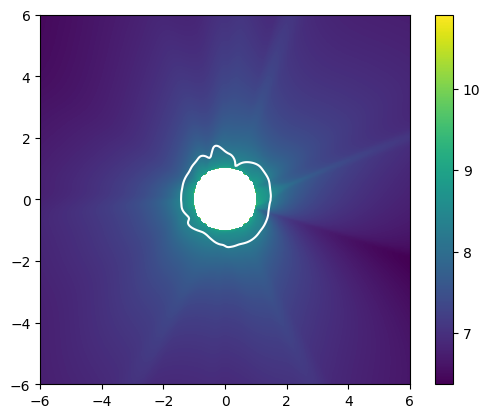

In [ ]:
im = plt.imshow(np.log10(omega_pe_3d[:,150,:]).T,extent= [x_grid[0], x_grid[-1], y_grid[0], y_grid[-1]])
plt.contour(x_grid, y_grid, (omega_pe_3d[:,150,:]), levels=[30e6*2*np.pi], colors='w')
plt.colorbar(im)

In [ ]:

from scipy.interpolate import RegularGridInterpolator


freq = 40e6
omega0 = 2*np.pi*freq
#starting_point = np.array([[4,0,1.1],[4,-0.8,0]])
z_start = np.linspace(-1.5, 1.5, 18)
x_start = np.zeros_like(z_start)+4.5
y_start = np.zeros_like(z_start)
starting_point = np.vstack([x_start, y_start, z_start]).T

kvec_in_norm = np.tile( np.array([[-1,0,0]]), (len(starting_point),1))


# interpolate the omega_pe to the starting point, 3d linear interpolation
# use scipy.interpolate.RegularGridInterpolator

omega_pe_interp = RegularGridInterpolator((x_grid, y_grid, z_grid), omega_pe_3d)
domega_pe_dx_interp = RegularGridInterpolator((x_grid, y_grid, z_grid), domega_pe_dx_3d)
domega_pe_dy_interp = RegularGridInterpolator((x_grid, y_grid, z_grid), domega_pe_dy_3d)
domega_pe_dz_interp = RegularGridInterpolator((x_grid, y_grid, z_grid), domega_pe_dz_3d)

omega_pe_starting_point = np.zeros_like(starting_point)

omega_pe_starting_point = omega_pe_interp(starting_point)

kc0 = (omega0**2 - omega_pe_starting_point**2)**0.5

kvec = kvec_in_norm * kc0[:,np.newaxis]

In [ ]:
k_vec_start  = kvec
r_vec_start = starting_point

In [ ]:

kc = np.sqrt(np.sum(k_vec_start**2))
k_vec = k_vec_start
r_vec = r_vec_start
kc_cur = kc


dt = 5e-3


r_record = []
k_record = []

N_steps = 12000

for i in range(N_steps):

    if i%10 == 0:
        r_record.append(r_vec)
        k_record.append(k_vec)

    omega_pe = omega_pe_interp(r_vec)
    omega = np.sqrt(omega_pe**2 + kc_cur**2)
    domega_pe_dxyz = np.array([domega_pe_dx_interp(r_vec),
                                domega_pe_dy_interp(r_vec),
                                domega_pe_dz_interp(r_vec)]).T
    dr_vec = c_r/omega[:,None]*k_vec
    dk_vec = -omega_pe[:,None]/omega[:,None]* domega_pe_dxyz *c_r

    k_vec = k_vec + dk_vec*dt
    r_vec = r_vec + dr_vec*dt

#TODO use a solver

In [ ]:
r_record = np.array(r_record)
k_record = np.array(k_record)

In [ ]:
r_record.shape

(1200, 18, 3)

(-2.5, 2.5)

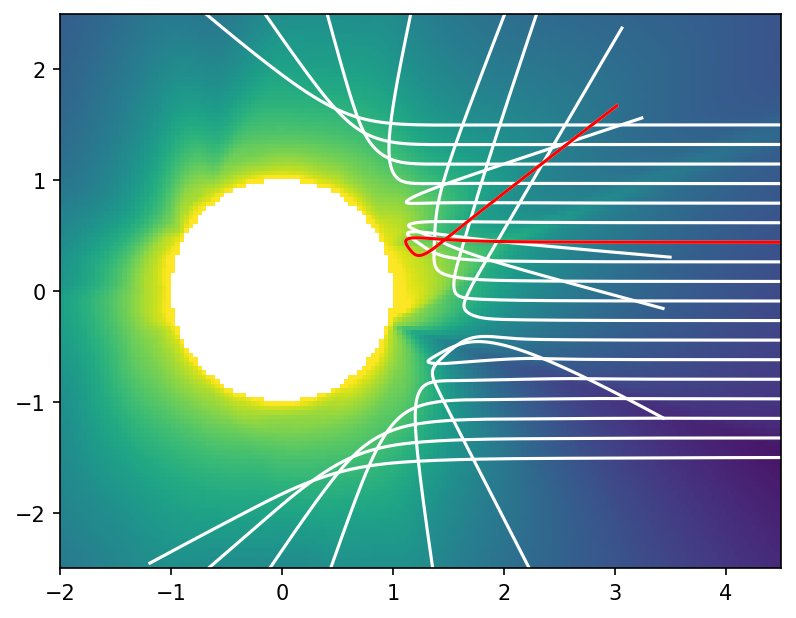

In [ ]:
plt.figure(dpi=150)
plt.imshow(np.log10(omega_pe_3d[:,150,:].T),extent= [x_grid[0], x_grid[-1], y_grid[0], y_grid[-1]],
           vmax=9)

for i in range((r_record.shape[1])):
    plt.plot(r_record[:,i,0], r_record[:,i,2], 'w')

plt.plot(r_record[:,11,0], r_record[:,11,2], 'r')

plt.xlim(-2,4.5)
plt.ylim(-2.5,2.5)

In [ ]:
one_trace  =  r_record[:,11,:].squeeze()

In [34]:

# sample along the trave
from tqdm import tqdm
trace_rtp = np.array([xyz_to_rtp(*r) for r in one_trace])

# plasma temperature [K]
t_var_trace = model['t'].sample_at_coords(lon=trace_rtp[:,2]*180/np.pi*u.deg,
    lat=trace_rtp[:,1]*180/np.pi*u.deg,r=trace_rtp[:,0]*u.Rsun).value

# electron density [cm^-3]
rho_var_trace = model['rho'].sample_at_coords(lon=trace_rtp[:,2]*180/np.pi*u.deg,
    lat=trace_rtp[:,1]*180/np.pi*u.deg,r=trace_rtp[:,0]*u.Rsun).value

# magnetic field [G]
bp_var_trace = model['bp'].sample_at_coords(lon=trace_rtp[:,2]*180/np.pi*u.deg,
    lat=trace_rtp[:,1]*180/np.pi*u.deg,r=trace_rtp[:,0]*u.Rsun).value
bt_var_trace = model['bt'].sample_at_coords(lon=trace_rtp[:,2]*180/np.pi*u.deg,
    lat=trace_rtp[:,1]*180/np.pi*u.deg,r=trace_rtp[:,0]*u.Rsun).value
br_var_trace = model['br'].sample_at_coords(lon=trace_rtp[:,2]*180/np.pi*u.deg,
    lat=trace_rtp[:,1]*180/np.pi*u.deg,r=trace_rtp[:,0]*u.Rsun).value

#b_var_trace = np.sqrt(bp_var_trace**2 + br_var_trace**2 + bt_var_trace**2)



In [ ]:
trace_rtp.shape

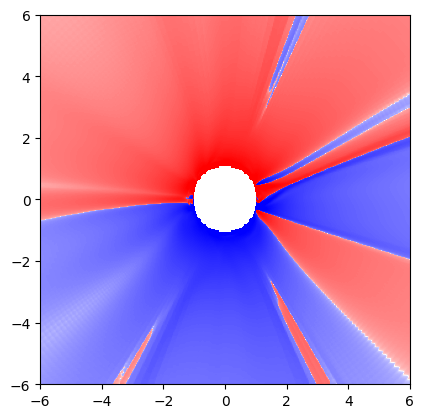

In [29]:
plt.imshow(domega_pe_dz_3d[:,150,:].T,extent= [x_grid[0], x_grid[-1], y_grid[0], y_grid[-1]],
           norm=colors.SymLogNorm(linthresh=1e4, linscale=1, vmin=-1e9, vmax=1e9), cmap='bwr')

In [ ]:
# calculate the ray tau